In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tensorflow.__version__

'2.9.2'

In [ ]:
import tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)
snapshot_folder = '/content/drive/MyDrive/vignesh/chatbot_weights_v2'
data_path = '/content/sample_data/cornell movie-dialogs corpus/'

# assert os.path.isdir(snapshot_folder) == True
# assert os.path.isdir(data_path) == True
print(tf.__version__)

test = False
print('test: ', test)
if test:
    LSTM_units = 10
    batch_size = 4
    emb_dim = 10
else:
    LSTM_units = 256
    batch_size = 32
    emb_dim = 50

init_lr = 0.0005

2.9.2
test:  False


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cornell movie-dialogs corpus.zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/vignesh/glove.twitter.27B (1).zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [ ]:
def progressBar(value, endvalue, bar_length=20, job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

#### Reading the data

In [ ]:
# Load the data
lines = open(data_path+'movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open(data_path+'movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each line's id with its text
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the conversations' lines' ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
# Check if we have loaded the data correctly
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

In [ ]:
# replacing many abbreviations and lower casing the words
def replace_phrase(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p
replaced_pairs = replace_phrase(pairs)
replaced_pairs[:5]

[['can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part  please'],
 ['not the hacking and gagging and spitting part  please',
  'okay then how about we try out some french cuisine  saturday  night'],
 ['you are asking me out  that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault  we did not have a proper introduction', 'cameron']]

In [ ]:
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuation from each token
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove tokens with numbers in them
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]

In [ ]:
# adding the start and end token to our sentences
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

[['<startseq> can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again <endseq>',
  '<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>'],
 ['<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>',
  '<startseq> not the hacking and gagging and spitting part please <endseq>'],
 ['<startseq> not the hacking and gagging and spitting part please <endseq>',
  '<startseq> okay then how about we try out some french cuisine saturday night <endseq>'],
 ['<startseq> you are asking me out that is so cute that is your name again <endseq>',
  '<startseq> forget it <endseq>'],
 ['<startseq> no no it is my fault we did not have a proper introduction <endseq>',
  '<startseq> cameron <endseq>']]

In [ ]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, we caculate the max length that 80% of data can be placed in
def max_length(pairs,prct):
    # Create a list of all the captions
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    print('percentile {} of len of questions: {}'.format(prct,np.percentile(length_questions, prct)))
    print('longest sentence: ', max(length_questions))
    print()
    print('percentile {} of len of answers: {}'.format(prct,np.percentile(length_answers, prct)))
    print('longest sentence: ', max(length_answers))
    print()
    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len questions for training: ', max_len_q)
print('max-len answers for training: ', max_len_a)

percentile 80 of len of questions: 18.0
longest sentence:  321

percentile 80 of len of answers: 18.0
longest sentence:  557

max-len questions for training:  18
max-len answers for training:  18


In [ ]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

145905

#### Creating the vocabulary

In [ ]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    # Create a list of all the captions
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data atleast 20 times
short_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
# removing one character words from vocab except for 'a'
for v in short_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        short_vocab.remove(v) 

short_vocab = sorted(short_vocab)[1:]
short_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [ ]:
vocab_len = len(short_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len

14500

In [ ]:
# keep the pairs that have the words in vocab
def trimRareWords(voc, pairs):
    # Filter out pairs with trimmed words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(short_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

Job Completion: [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [ ]:
#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(short_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0. but padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

#### making the model

In [ ]:
 # Making the embedding mtrix
def make_embedding_layer(embedding_dim=100, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = '/content/sample_data/glove.twitter.27B.50d.txt'
        embeddings_index = {} 
        f = open("/content/sample_data/glove.twitter.27B.50d.txt", encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        # Get 200-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=emb_dim, glove=not test)

Loading glove...
GloVe  50  loded!


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        self.embeddings = embeddings
        
        self.Bidirectional1 = Bidirectional(LSTM(enc_units, return_sequences=True, 
                                                return_state=True,
                                                recurrent_initializer='glorot_uniform',
                                                name='lstm_1'))
                                                                                                
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        output, stateh_f,statef_c,stateh_b,statec_b= self.Bidirectional1(x)

        return output, stateh_f,statef_c,stateh_b,statec_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(emb_dim, LSTM_units)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # used for attention
        self.attention = BahdanauAttention(self.units)
        self.decoder_lstm_l1 = LSTM(self.units, return_sequences=True, 
                                  return_state= False, recurrent_initializer='glorot_uniform' ,name='decoder_lstm1')
        self.decoder_lstm_l2 = LSTM(self.units, return_sequences=False, 
                                  return_state= True, recurrent_initializer='glorot_uniform' ,name='decoder_lstm2') 
        self.dropout = Dropout(0.4)
        
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the lstm
        x = self.decoder_lstm_l1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.decoder_lstm_l2(x)
        x = self.fc(output)
        return x, state_f, attention_weights

In [ ]:
decoder = Decoder(vocab_len, emb_dim, LSTM_units)

## Replying questions

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
import unicodedata
import matplotlib.ticker as ticker

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [ ]:
def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, LSTM_units))]
    enc_out, enc_hiddenfh,enc_hiddenfc,enc_hiddenbh,enc_hiddenbc = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hiddenfh, enc_hiddenbh])
    #dec_hidden=enc_hidden
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [ ]:
def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

In [ ]:
def beam_search(sentence, k=3, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, LSTM_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(init_lr)
from sklearn.preprocessing import OneHotEncoder
def loss_function(real, pred):
    # ohe=OneHotEncoder()
    # real=ohe.fit_transform(real)
    # pred=ohe.fit_transform(pred)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:


# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(snapshot_folder, str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hiddenfh,enc_hiddenfc,enc_hiddenbh,enc_hiddenbc = encoder(inp, enc_hidden)

        dec_hidden = Concatenate(axis=-1)([enc_hiddenfh, enc_hiddenbh])
        #enc_output, enc_hidden_f = encoder(inp, enc_hidden)
        
        #dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        #dec_hidden=enc_hidden_f
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            print(targ[:,t])
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 100 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1

In [ ]:
def test_bot(k = 3, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q= 'Are you my friend'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Who are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

In [ ]:
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

In [ ]:
np.__version__

'1.21.6'

In [ ]:
tf.__version__

'2.9.2'

Tensor("strided_slice:0", shape=(32,), dtype=int32)
Tensor("strided_slice_3:0", shape=(32,), dtype=int32)
Tensor("strided_slice_6:0", shape=(32,), dtype=int32)
Tensor("strided_slice_9:0", shape=(32,), dtype=int32)
Tensor("strided_slice_12:0", shape=(32,), dtype=int32)
Tensor("strided_slice_15:0", shape=(32,), dtype=int32)
Tensor("strided_slice_18:0", shape=(32,), dtype=int32)
Tensor("strided_slice_21:0", shape=(32,), dtype=int32)
Tensor("strided_slice_24:0", shape=(32,), dtype=int32)
Tensor("strided_slice_27:0", shape=(32,), dtype=int32)
Tensor("strided_slice_30:0", shape=(32,), dtype=int32)
Tensor("strided_slice_33:0", shape=(32,), dtype=int32)
Tensor("strided_slice_36:0", shape=(32,), dtype=int32)
Tensor("strided_slice_39:0", shape=(32,), dtype=int32)
Tensor("strided_slice_42:0", shape=(32,), dtype=int32)
Tensor("strided_slice_45:0", shape=(32,), dtype=int32)
Tensor("strided_slice_48:0", shape=(32,), dtype=int32)
Tensor("strided_slice:0", shape=(32,), dtype=int32)
Tensor("strided_sli

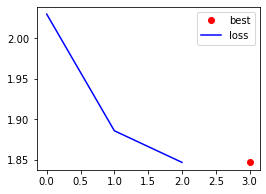

Best epoch so far:  3  smallest loss: 1.8468346974206349
Time taken for the epoch 258.558 sec

Epoch 4 Batch 598 Loss: 1.4734
Epoch 4 Batch 1196 Loss: 2.5174
Epoch 4 Batch 1794 Loss: 2.0934
Epoch 4 Batch 2392 Loss: 2.1193
Epoch 4 Batch 2990 Loss: 1.9312
Epoch 4 Batch 3588 Loss: 2.3179

*** Epoch 4 Loss 1.8187 ***

####################
Greedy| Q: Hello ?  A: yes 
%
Greedy| Q: How are you ?  A: i am not going to be a little 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am not you 
%
Greedy| Q: What your favorite restaurant ?  A: i am not you 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
check point saved!
Best epoch so far:  4  smallest loss: 1.8187218806565024
Time taken for the epoch 258.668 sec

Epoch 5 Batch 598 Loss: 1.4864
Epoch 5 Batch 1196 Loss: 2.1593
Epoch 5 Batch 1794 Loss: 1.9899
Epoch 5 Batch 2392 Loss: 2.0927
Epoch 5 Batch 2990 Loss: 1.9029
Epoch 5 Batch 3588 Los

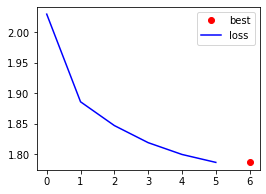

Best epoch so far:  6  smallest loss: 1.7863035953599276
Time taken for the epoch 258.550 sec

Epoch 7 Batch 598 Loss: 1.7323
Epoch 7 Batch 1196 Loss: 2.1993
Epoch 7 Batch 1794 Loss: 2.2032
Epoch 7 Batch 2392 Loss: 2.2347
Epoch 7 Batch 2990 Loss: 1.5429
Epoch 7 Batch 3588 Loss: 2.0876

*** Epoch 7 Loss 1.7765 ***

####################
Greedy| Q: Hello ?  A: i am sorry 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of the department 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Who are you ?  A: i am not going to be 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
check point saved!
Best epoch so far:  7  smallest loss: 1.7765251888401559
Time taken for the epoch 258.637 sec

Epoch 8 Batch 598 Loss: 1.6503
Epoch 8 Batch 1196 Loss: 2.2796
Epoch 8 Batch 1794 Loss: 2.2465
Epoch 8 Batch 2392 Loss: 2.1369
Ep

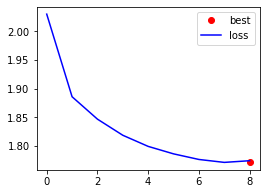

Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 259.943 sec

Epoch 10 Batch 598 Loss: 1.4827
Epoch 10 Batch 1196 Loss: 2.2730
Epoch 10 Batch 1794 Loss: 2.1334
Epoch 10 Batch 2392 Loss: 1.9196
Epoch 10 Batch 2990 Loss: 1.9414
Epoch 10 Batch 3588 Loss: 2.3702

*** Epoch 10 Loss 1.7768 ***

####################
Greedy| Q: Hello ?  A: hi 
%
Greedy| Q: How are you ?  A: i am not a little 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am sorry i am not going to be a lot of a lot of the department 
%
Greedy| Q: What your favorite restaurant ?  A: yes 
%
Greedy| Q: Who are you ?  A: i am not a little 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 259.848 sec

Epoch 11 Batch 598 Loss: 1.5421
Epoch 11 Batch 1196 Loss: 1.9443
Epoch 11 Batch 1794 Loss: 1.7676
Epoch 11 Batch 2392 Loss: 1.9532
Epoch 11 Batch 2990 Los

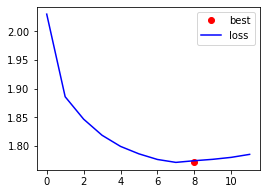

Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 258.220 sec

Epoch 13 Batch 598 Loss: 1.6382
Epoch 13 Batch 1196 Loss: 2.2467
Epoch 13 Batch 1794 Loss: 2.2905
Epoch 13 Batch 2392 Loss: 2.2017
Epoch 13 Batch 2990 Loss: 1.8203
Epoch 13 Batch 3588 Loss: 2.3018

*** Epoch 13 Loss 1.7891 ***

####################
Greedy| Q: Hello ?  A: i have been thinking 
%
Greedy| Q: How are you ?  A: i am not sure i am just a lot of things 
%
Greedy| Q: Are you my friend ?  A: yes i am not interested 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of things 
%
Greedy| Q: What your favorite restaurant ?  A: yes 
%
Greedy| Q: Who are you ?  A: i am 
%
Greedy| Q: Do you want to go out ?  A: no i do not know what you are going to do it 
####################
Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 258.029 sec

Epoch 14 Batch 598 Loss: 1.6080
Epoch 14 Batch 1196 Loss: 2.2984
Epoch 14 Batch 1794 Loss: 2.1943
Epoch 14 

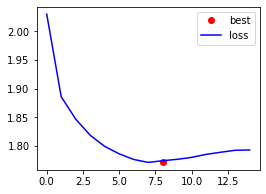

Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 258.446 sec

Epoch 16 Batch 598 Loss: 1.5309
Epoch 16 Batch 1196 Loss: 2.0021
Epoch 16 Batch 1794 Loss: 1.9026
Epoch 16 Batch 2392 Loss: 2.0160
Epoch 16 Batch 2990 Loss: 1.8960
Epoch 16 Batch 3588 Loss: 2.2890

*** Epoch 16 Loss 1.7914 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: Are you my friend ?  A: yes sir 
%
Greedy| Q: What are you doing ?  A: i am not going to be alone 
%
Greedy| Q: What your favorite restaurant ?  A: yes 
%
Greedy| Q: Who are you ?  A: i am the one who knew me 
%
Greedy| Q: Do you want to go out ?  A: yes 
####################
Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 258.109 sec

Epoch 17 Batch 598 Loss: 1.6038
Epoch 17 Batch 1196 Loss: 1.8978
Epoch 17 Batch 1794 Loss: 1.8702
Epoch 17 Batch 2392 Loss: 1.8669
Epoch 17 Batch 2990 Loss: 1.8369
Epoch 17 Batch 3588 Loss: 2.1055

*

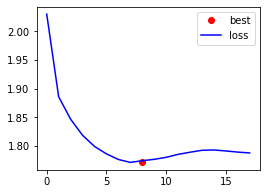

Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 256.905 sec

Epoch 19 Batch 598 Loss: 1.6224
Epoch 19 Batch 1196 Loss: 2.3317
Epoch 19 Batch 1794 Loss: 2.2592
Epoch 19 Batch 2392 Loss: 2.1199
Epoch 19 Batch 2990 Loss: 1.8574
Epoch 19 Batch 3588 Loss: 2.3227

*** Epoch 19 Loss 1.7908 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: Are you my friend ?  A: yes i am not interested 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Who are you ?  A: i am 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 255.666 sec

Epoch 20 Batch 598 Loss: 1.4307
Epoch 20 Batch 1196 Loss: 2.4194
Epoch 20 Batch 1794 Loss: 2.0794
Epoch 20 Batch 2392 Loss: 2.0354
Epoch 20 Batch 2990 Loss: 1.9444
Epoch 20 Batch 3588 Loss: 2

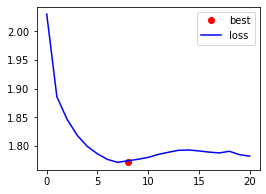

Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 255.654 sec

Epoch 22 Batch 598 Loss: 1.5851
Epoch 22 Batch 1196 Loss: 2.0504
Epoch 22 Batch 1794 Loss: 1.9540
Epoch 22 Batch 2392 Loss: 1.8629
Epoch 22 Batch 2990 Loss: 1.9733
Epoch 22 Batch 3588 Loss: 2.1789

*** Epoch 22 Loss 1.7805 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine i am fine i am fine i am fine i am fine i am fine 
%
Greedy| Q: Are you my friend ?  A: i do not know 
%
Greedy| Q: What are you doing ?  A: i am not going to be 
%
Greedy| Q: What your favorite restaurant ?  A: yes 
%
Greedy| Q: Who are you ?  A: i am 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 255.433 sec

Epoch 23 Batch 598 Loss: 1.7826
Epoch 23 Batch 1196 Loss: 2.2082
Epoch 23 Batch 1794 Loss: 2.1251
Epoch 23 Batch 2392 Loss: 2.3134
Epoch 23 Batch 2990 Loss: 1.5721
Epoch 

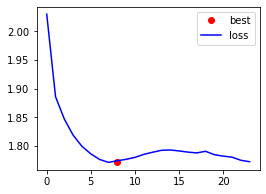

Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 257.535 sec

Epoch 25 Batch 598 Loss: 1.5211
Epoch 25 Batch 1196 Loss: 2.4280
Epoch 25 Batch 1794 Loss: 2.1402
Epoch 25 Batch 2392 Loss: 1.9936
Epoch 25 Batch 2990 Loss: 1.9563
Epoch 25 Batch 3588 Loss: 2.3006

*** Epoch 25 Loss 1.7786 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine i am fine i am fine i am fine i am fine i am fine 
%
Greedy| Q: Are you my friend ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What your favorite restaurant ?  A: yes 
%
Greedy| Q: Who are you ?  A: i am the one who brought me out 
%
Greedy| Q: Do you want to go out ?  A: yes 
####################
Best epoch so far:  8  smallest loss: 1.7714229149262044
Time taken for the epoch 255.741 sec

Epoch 26 Batch 598 Loss: 1.5374
Epoch 26 Batch 1196 Loss: 2.4639
Epoch 26 Batch 1

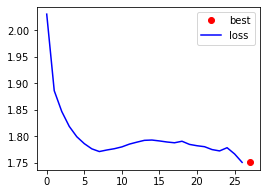

Best epoch so far:  27  smallest loss: 1.7510176265316069
Time taken for the epoch 255.739 sec

Epoch 28 Batch 598 Loss: 1.7324
Epoch 28 Batch 1196 Loss: 2.3788
Epoch 28 Batch 1794 Loss: 1.9984
Epoch 28 Batch 2392 Loss: 2.4011
Epoch 28 Batch 2990 Loss: 1.4066
Epoch 28 Batch 3588 Loss: 1.9409

*** Epoch 28 Loss 1.7449 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine i am fine i am fine i am fine i am fine i am fine 
%
Greedy| Q: Are you my friend ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am sorry i am afraid 
%
Greedy| Q: What your favorite restaurant ?  A: yes 
%
Greedy| Q: Who are you ?  A: i am the one who is coming 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  28  smallest loss: 1.744883584830131
Time taken for the epoch 255.795 sec

Epoch 29 Batch 598 Loss: 1.6335
Epoch 29 Batch 1196 Loss: 2.2964
Epoch 29 Batch 1794 Loss: 2.1157
Epoch 29 Batch 2392 Loss: 2.

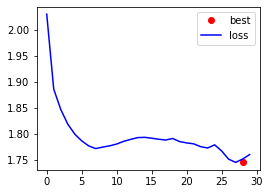

Best epoch so far:  28  smallest loss: 1.744883584830131
Time taken for the epoch 256.122 sec

Epoch 31 Batch 598 Loss: 1.3698
Epoch 31 Batch 1196 Loss: 2.4423
Epoch 31 Batch 1794 Loss: 1.9619
Epoch 31 Batch 2392 Loss: 2.1102
Epoch 31 Batch 2990 Loss: 1.9745
Epoch 31 Batch 3588 Loss: 2.3817

*** Epoch 31 Loss 1.7567 ***

####################
Greedy| Q: Hello ?  A: i am sorry 
%
Greedy| Q: How are you ?  A: i am fine today i am fine today i am fine today i am fine today i am 
%
Greedy| Q: Are you my friend ?  A: i am not a long time 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i am a of friend 
%
Greedy| Q: Who are you ?  A: i am i am the 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  28  smallest loss: 1.744883584830131
Time taken for the epoch 255.497 sec

Epoch 32 Batch 598 Loss: 1.4576
Epoch 32 Batch 1196 Loss: 2.1200
Epoch 32 Batch 1794 Loss: 1.6640
Epoch 32 Batch 2392 Loss: 2.0181
Epoch 

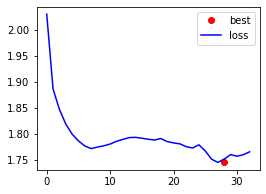

Best epoch so far:  28  smallest loss: 1.744883584830131
Time taken for the epoch 256.208 sec

Epoch 34 Batch 598 Loss: 1.7438
Epoch 34 Batch 1196 Loss: 2.2312
Epoch 34 Batch 1794 Loss: 2.1695
Epoch 34 Batch 2392 Loss: 2.5262
Epoch 34 Batch 2990 Loss: 1.7614
Epoch 34 Batch 3588 Loss: 2.0446

*** Epoch 34 Loss 1.7565 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine i am 
%
Greedy| Q: Are you my friend ?  A: yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes 
%
Greedy| Q: What are you doing ?  A: i am afraid i am afraid i am afraid i am afraid i am afraid i am afraid 
%
Greedy| Q: What your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Who are you ?  A: i am the one who are a little bit out of me 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  28  smallest loss: 1.744883584830131
Time taken for the epoch 256.254 sec

Epoch 35 Batch 598 Loss: 1.6103
Epoch 35 Batch 1196 Loss: 2.4097


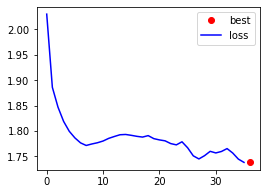

Best epoch so far:  36  smallest loss: 1.7380955100424673
Time taken for the epoch 256.547 sec

Epoch 37 Batch 598 Loss: 1.3985
Epoch 37 Batch 1196 Loss: 2.2467
Epoch 37 Batch 1794 Loss: 2.0374
Epoch 37 Batch 2392 Loss: 2.0248
Epoch 37 Batch 2990 Loss: 1.9844
Epoch 37 Batch 3588 Loss: 2.2519

*** Epoch 37 Loss 1.7302 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i came to me 
%
Greedy| Q: Who are you ?  A: i am the one who ever been to be 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  37  smallest loss: 1.7302109440267335
Time taken for the epoch 256.810 sec

Epoch 38 Batch 598 Loss: 1.5388
Epoch 38 Batch 1196 Loss: 1.9449
Epoch 38 Batch 1794 Loss: 1.8026
Epoch 38 Batch 2392 Loss: 1.9035
E

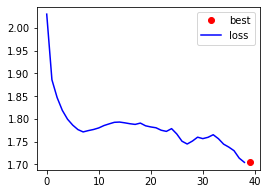

Best epoch so far:  39  smallest loss: 1.7045377658556113
Time taken for the epoch 255.832 sec

Epoch 40 Batch 598 Loss: 1.6639
Epoch 40 Batch 1196 Loss: 2.2299
Epoch 40 Batch 1794 Loss: 2.1151
Epoch 40 Batch 2392 Loss: 1.9839
Epoch 40 Batch 2990 Loss: 1.7418
Epoch 40 Batch 3588 Loss: 2.0975

*** Epoch 40 Loss 1.6943 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine i am fine fine thank you 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am trying to stay here 
%
Greedy| Q: What your favorite restaurant ?  A: oh yeah with the or two 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  40  smallest loss: 1.6943451837057923
Time taken for the epoch 255.878 sec

Epoch 41 Batch 598 Loss: 1.4084
Epoch 41 Batch 1196 Loss: 2.3803
Epoch 41 Batch 1794 Loss: 2.0219
Epoch 41 Batch 2392 Loss: 1.9083
Epoch 41 Batch 299

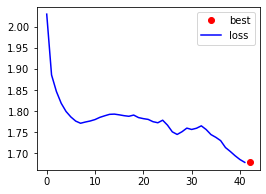

Best epoch so far:  42  smallest loss: 1.6786765361755083
Time taken for the epoch 256.328 sec

Epoch 43 Batch 598 Loss: 1.4357
Epoch 43 Batch 1196 Loss: 1.9649
Epoch 43 Batch 1794 Loss: 1.6102
Epoch 43 Batch 2392 Loss: 2.0587
Epoch 43 Batch 2990 Loss: 1.7931
Epoch 43 Batch 3588 Loss: 2.2655

*** Epoch 43 Loss 1.6670 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: Are you my friend ?  A: yes i am sorry i am sorry i am sorry i am sorry i am sorry i am 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i am not a little own side 
%
Greedy| Q: Who are you ?  A: i am 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  43  smallest loss: 1.6669780462440824
Time taken for the epoch 256.263 sec

Epoch 44 Batch 598 Loss: 1.5791
Epoch 44 Batch 1196 Loss: 2.2639
Epoch 44 Batch 1794 L

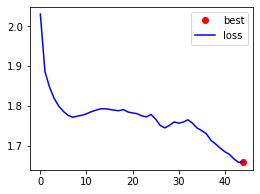

Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 257.285 sec

Epoch 46 Batch 598 Loss: 1.5119
Epoch 46 Batch 1196 Loss: 2.2431
Epoch 46 Batch 1794 Loss: 2.1004
Epoch 46 Batch 2392 Loss: 2.0490
Epoch 46 Batch 2990 Loss: 1.7777
Epoch 46 Batch 3588 Loss: 2.1548

*** Epoch 46 Loss 1.6677 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine enough i mean 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: oh oh i am sorry by the just change the just change the just change the just change 
%
Greedy| Q: Who are you ?  A: i am a good time ever help me 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 257.389 sec

Epoch 47 Batch 598 Loss: 1.2293
Epoch 47 Batch 1196 Loss: 2.4323
E

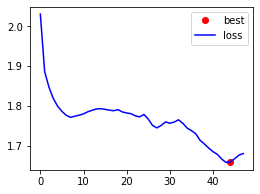

Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 256.209 sec

Epoch 49 Batch 598 Loss: 1.5507
Epoch 49 Batch 1196 Loss: 1.8628
Epoch 49 Batch 1794 Loss: 1.8931
Epoch 49 Batch 2392 Loss: 1.9078
Epoch 49 Batch 2990 Loss: 1.8198
Epoch 49 Batch 3588 Loss: 2.1310

*** Epoch 49 Loss 1.6738 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am sorry i am afraid i am sorry i am afraid i am sorry i am afraid 
%
Greedy| Q: What your favorite restaurant ?  A: oh yeah else 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 257.688 sec

Epoch 50 Batch 598 Loss: 1.5225
Epoch 50 Batch 1196 Loss: 2.1179
Epoch 50 Batch 1794 Loss: 1.9717
Epoch 50 Batch 2392 Loss: 2.2583
Epoch 50 Batch 2990 Loss: 1.642

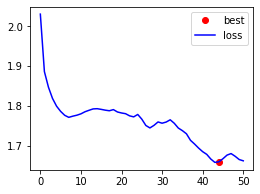

Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 256.277 sec

Epoch 52 Batch 598 Loss: 1.3096
Epoch 52 Batch 1196 Loss: 2.3674
Epoch 52 Batch 1794 Loss: 1.7580
Epoch 52 Batch 2392 Loss: 1.8826
Epoch 52 Batch 2990 Loss: 1.8531
Epoch 52 Batch 3588 Loss: 2.1804

*** Epoch 52 Loss 1.6697 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am afraid i am afraid i am afraid i am afraid i am afraid i am afraid 
%
Greedy| Q: What your favorite restaurant ?  A: oh yeah down the but i knew he met 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: i do not know i do not know i do not know i do not know i do 
####################
Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 258.358 sec

Epoch 53 Batch 598 Loss: 1.4246
Epoch 53 Batch 1196 Loss: 2.2927
Epoch 53 Batch

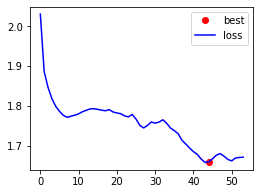

Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 257.034 sec

Epoch 55 Batch 598 Loss: 1.5732
Epoch 55 Batch 1196 Loss: 2.1478
Epoch 55 Batch 1794 Loss: 1.9332
Epoch 55 Batch 2392 Loss: 2.0396
Epoch 55 Batch 2990 Loss: 1.4767
Epoch 55 Batch 3588 Loss: 1.8730

*** Epoch 55 Loss 1.6616 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am sorry 
%
Greedy| Q: What are you doing ?  A: i am sorry i am trying to kill myself 
%
Greedy| Q: What your favorite restaurant ?  A: oh yeah sir 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  44  smallest loss: 1.658547138244918
Time taken for the epoch 256.577 sec

Epoch 56 Batch 598 Loss: 1.4569
Epoch 56 Batch 1196 Loss: 2.2052
Epoch 56 Batch 1794 Loss: 1.9873
Epoch 56 Batch 2392 Loss: 1.9883
Epoch 56 Batch 2990 Loss: 1.7669
Epoch 56 Batch 3588 Los

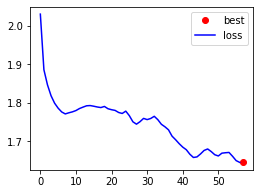

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 258.588 sec

Epoch 58 Batch 598 Loss: 1.3312
Epoch 58 Batch 1196 Loss: 2.3232
Epoch 58 Batch 1794 Loss: 1.8635
Epoch 58 Batch 2392 Loss: 1.8306
Epoch 58 Batch 2990 Loss: 1.9007
Epoch 58 Batch 3588 Loss: 2.3958

*** Epoch 58 Loss 1.6484 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: of course i am trying 
%
Greedy| Q: What are you doing ?  A: i am trying to stay here 
%
Greedy| Q: What your favorite restaurant ?  A: pretty 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: i do not think i am going to know what 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 257.546 sec

Epoch 59 Batch 598 Loss: 1.3495
Epoch 59 Batch 1196 Loss: 1.8639
Epoch 59 Batch 1794 Loss: 1.6056
Epoch 59 Batch 2392 Loss: 1.7723
Epoch 59 Batch 2990 Loss:

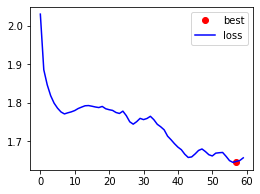

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 257.293 sec

Epoch 61 Batch 598 Loss: 1.4469
Epoch 61 Batch 1196 Loss: 2.2060
Epoch 61 Batch 1794 Loss: 1.9585
Epoch 61 Batch 2392 Loss: 2.0790
Epoch 61 Batch 2990 Loss: 1.6891
Epoch 61 Batch 3588 Loss: 2.1502

*** Epoch 61 Loss 1.6571 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: oh i am fine i am fine i am fine i am fine i am fine i am 
%
Greedy| Q: Are you my friend ?  A: i am sorry 
%
Greedy| Q: What are you doing ?  A: i am getting married 
%
Greedy| Q: What your favorite restaurant ?  A: oh am i being her she was a very new i told me 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.514 sec

Epoch 62 Batch 598 Loss: 1.4690
Epoch 62 Batch 1196 Loss: 2.3157
Epoch 62 Batch 1794 Loss: 1.8899
Epoch 62 Batch 2

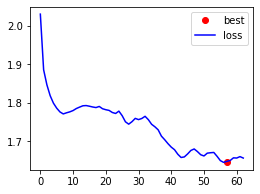

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 257.810 sec

Epoch 64 Batch 598 Loss: 1.3080
Epoch 64 Batch 1196 Loss: 2.0008
Epoch 64 Batch 1794 Loss: 1.5037
Epoch 64 Batch 2392 Loss: 1.8796
Epoch 64 Batch 2990 Loss: 1.8782
Epoch 64 Batch 3588 Loss: 2.3461

*** Epoch 64 Loss 1.6579 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am trying to kill her last night 
%
Greedy| Q: What are you doing ?  A: just a little bit of it 
%
Greedy| Q: What your favorite restaurant ?  A: pretty 
%
Greedy| Q: Who are you ?  A: i am a good time 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.165 sec

Epoch 65 Batch 598 Loss: 1.4609
Epoch 65 Batch 1196 Loss: 1.8642
Epoch 65 Batch 1794 Loss: 1.6730
Epoch 65 Batch 2392 Loss: 1.7709
Epoch 65 Batch 2990 Loss: 1.8197
Epoch 65 Batch 3588 

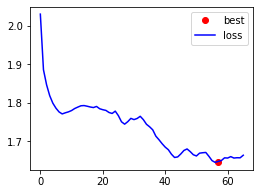

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 257.509 sec

Epoch 67 Batch 598 Loss: 1.4981
Epoch 67 Batch 1196 Loss: 2.3093
Epoch 67 Batch 1794 Loss: 1.9833
Epoch 67 Batch 2392 Loss: 2.0309
Epoch 67 Batch 2990 Loss: 1.7531
Epoch 67 Batch 3588 Loss: 2.2124

*** Epoch 67 Loss 1.6725 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: trying to stay here 
%
Greedy| Q: What your favorite restaurant ?  A: with 
%
Greedy| Q: Who are you ?  A: yes night play games 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 258.910 sec

Epoch 68 Batch 598 Loss: 1.2480
Epoch 68 Batch 1196 Loss: 2.4938
Epoch 68 Batch 1794 Loss: 1.8277
Epoch 68 Batch 2392 Loss: 1.8822
Epoch 68 Batch 2990 Loss: 1.8528
Epoch 68 Batch 3588 Loss: 2.3022

*** Epoch 68 Loss 1

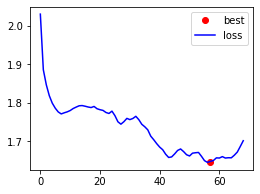

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 256.082 sec

Epoch 70 Batch 598 Loss: 1.4502
Epoch 70 Batch 1196 Loss: 1.9152
Epoch 70 Batch 1794 Loss: 1.6881
Epoch 70 Batch 2392 Loss: 1.8339
Epoch 70 Batch 2990 Loss: 1.8286
Epoch 70 Batch 3588 Loss: 2.4141

*** Epoch 70 Loss 1.7106 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no i have to be friends 
%
Greedy| Q: What are you doing ?  A: just a little bit of the way 
%
Greedy| Q: What your favorite restaurant ?  A: oh so so i am sure you are 
%
Greedy| Q: Who are you ?  A: i am a good time 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 256.152 sec

Epoch 71 Batch 598 Loss: 1.5608
Epoch 71 Batch 1196 Loss: 2.5605
Epoch 71 Batch 1794 Loss: 2.0438
Epoch 71 Batch 2392 Loss: 2.2930
Epoch 71 Batch 2990 Loss: 1.5265
Epoch 

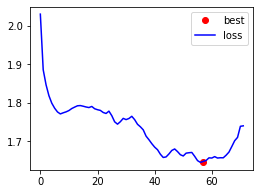

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.256 sec

Epoch 73 Batch 598 Loss: 1.3929
Epoch 73 Batch 1196 Loss: 2.5251
Epoch 73 Batch 1794 Loss: 1.9877
Epoch 73 Batch 2392 Loss: 1.8471
Epoch 73 Batch 2990 Loss: 1.9061
Epoch 73 Batch 3588 Loss: 2.3860

*** Epoch 73 Loss 1.7345 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine i am fine i am fine i am fine i am fine i am fine i am 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: just stay away 
%
Greedy| Q: What your favorite restaurant ?  A: oh so old 
%
Greedy| Q: Who are you ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 258.051 sec

Epoch 74 Batch 598 Loss: 1.3844
Epoch 74 Batch 1196 Loss: 2.4869
Epoch 74 Batch 1794 Loss: 1.9030
Epoch 74 Batch 2392 Loss: 1.7922
Epoch 74 Batch 2990 Loss: 2.0371
Epoch 74 Batch 

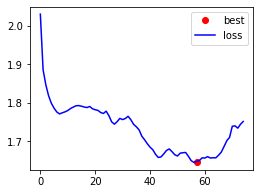

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 257.451 sec

Epoch 76 Batch 598 Loss: 1.6156
Epoch 76 Batch 1196 Loss: 2.5965
Epoch 76 Batch 1794 Loss: 2.0076
Epoch 76 Batch 2392 Loss: 2.2344
Epoch 76 Batch 2990 Loss: 1.4092
Epoch 76 Batch 3588 Loss: 1.9319

*** Epoch 76 Loss 1.7574 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: oh like a 
%
Greedy| Q: Who are you ?  A: yes i am not sure 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 258.315 sec

Epoch 77 Batch 598 Loss: 1.5751
Epoch 77 Batch 1196 Loss: 2.3836
Epoch 77 Batch 1794 Loss: 1.9952
Epoch 77 Batch 2392 Loss: 2.2150
Epoch 77 Batch 2990 Loss: 1.7468
Epoch

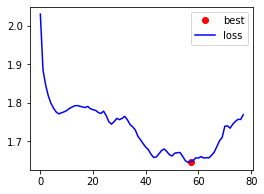

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.388 sec

Epoch 79 Batch 598 Loss: 1.2570
Epoch 79 Batch 1196 Loss: 2.7728
Epoch 79 Batch 1794 Loss: 1.9796
Epoch 79 Batch 2392 Loss: 2.0563
Epoch 79 Batch 2990 Loss: 2.0174
Epoch 79 Batch 3588 Loss: 2.6386

*** Epoch 79 Loss 1.7891 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: just a little bit of the 
%
Greedy| Q: What your favorite restaurant ?  A: funny what the want me to see there 
%
Greedy| Q: Who are you ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 257.441 sec

Epoch 80 Batch 598 Loss: 1.3963
Epoch 80 Batch 1196 Loss: 2.1655
Epoch 80 Batch 1794 Loss: 1.6082
Epoch 80 Batch 2392 Loss: 1.9946
Epoch 80 Batch 2990 Loss: 2.0829
Epoch 80 Batch 3588 Loss: 2.6307



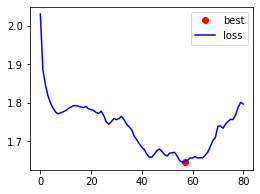

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.066 sec

Epoch 82 Batch 598 Loss: 1.5414
Epoch 82 Batch 1196 Loss: 2.5508
Epoch 82 Batch 1794 Loss: 2.1174
Epoch 82 Batch 2392 Loss: 2.3236
Epoch 82 Batch 2990 Loss: 1.7834
Epoch 82 Batch 3588 Loss: 2.0951

*** Epoch 82 Loss 1.8158 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am afraid 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: funny so like a i proud you are 
%
Greedy| Q: Who are you ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: yes 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 258.231 sec

Epoch 83 Batch 598 Loss: 1.5447
Epoch 83 Batch 1196 Loss: 2.6187
Epoch 83 Batch 1794 Loss: 2.0951
Epoch 83 Batch 2392 Loss: 2.1528
Epoch 83 Batch 2990 L

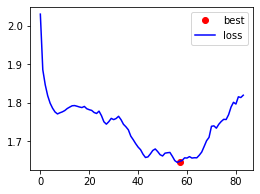

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.204 sec

Epoch 85 Batch 598 Loss: 1.3212
Epoch 85 Batch 1196 Loss: 2.4628
Epoch 85 Batch 1794 Loss: 1.8117
Epoch 85 Batch 2392 Loss: 2.0482
Epoch 85 Batch 2990 Loss: 2.1254
Epoch 85 Batch 3588 Loss: 2.5654

*** Epoch 85 Loss 1.8263 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: not careful 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: oh know what he is the a i might have a son been 
%
Greedy| Q: Who are you ?  A: yes meet i am not going to yes 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 260.345 sec

Epoch 86 Batch 598 Loss: 1.5556
Epoch 86 Batch 1196 Loss: 2.0929
Epoch 86 Batch 1794 Loss: 1.8836
Epoch 86 Ba

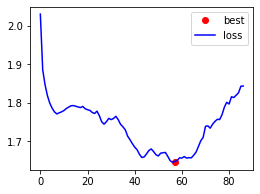

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 261.319 sec

Epoch 88 Batch 598 Loss: 1.6739
Epoch 88 Batch 1196 Loss: 2.5882
Epoch 88 Batch 1794 Loss: 2.0947
Epoch 88 Batch 2392 Loss: 2.1668
Epoch 88 Batch 2990 Loss: 1.9955
Epoch 88 Batch 3588 Loss: 2.3423

*** Epoch 88 Loss 1.8338 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no not much trouble oh my god was not fair 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i do 
%
Greedy| Q: Who are you ?  A: yes sir 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 260.908 sec

Epoch 89 Batch 598 Loss: 1.4747
Epoch 89 Batch 1196 Loss: 2.8407
Epoch 89 Batch 1794 Loss: 1.9911
Epoch 89 Batch 2392 Loss: 1.9441
Epoch 89 Batch

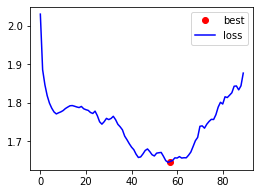

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 260.111 sec

Epoch 91 Batch 598 Loss: 1.4187
Epoch 91 Batch 1196 Loss: 2.2746
Epoch 91 Batch 1794 Loss: 1.7717
Epoch 91 Batch 2392 Loss: 2.0132
Epoch 91 Batch 2990 Loss: 1.9725
Epoch 91 Batch 3588 Loss: 2.8705

*** Epoch 91 Loss 1.8710 ***

####################
Greedy| Q: Hello ?  A: i have been hoping 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no i am sorry 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i will just love it was a shit out 
%
Greedy| Q: Who are you ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 260.896 sec

Epoch 92 Batch 598 Loss: 1.6704
Epoch 92 Batch 1196 Loss: 2.8077
Epoch 92 Batch 1794 Loss: 2.0506
Epoch 92 Batch 2392 Loss: 2.2897
Epoc

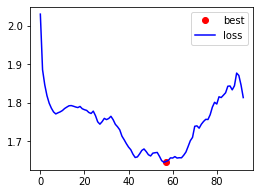

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.906 sec

Epoch 94 Batch 598 Loss: 1.6389
Epoch 94 Batch 1196 Loss: 2.6856
Epoch 94 Batch 1794 Loss: 1.9802
Epoch 94 Batch 2392 Loss: 1.8938
Epoch 94 Batch 2990 Loss: 1.8461
Epoch 94 Batch 3588 Loss: 2.2616

*** Epoch 94 Loss 1.7925 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine i am fine fine 
%
Greedy| Q: Are you my friend ?  A: not yet he is not here 
%
Greedy| Q: What are you doing ?  A: i do not know 
%
Greedy| Q: What your favorite restaurant ?  A: i want something new 
%
Greedy| Q: Who are you ?  A: no 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 259.352 sec

Epoch 95 Batch 598 Loss: 1.2935
Epoch 95 Batch 1196 Loss: 2.9379
Epoch 95 Batch 1794 Loss: 1.9497
Epoch 95 Batch 2392 Loss: 1.9780
Epoch 95 Batch 2990 Loss: 1.9596
Epoch 95 Batch 3588 Loss: 2

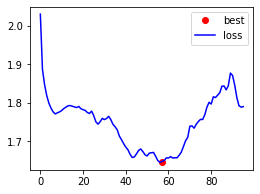

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 261.126 sec

Epoch 97 Batch 598 Loss: 1.6033
Epoch 97 Batch 1196 Loss: 2.1367
Epoch 97 Batch 1794 Loss: 1.8480
Epoch 97 Batch 2392 Loss: 1.9457
Epoch 97 Batch 2990 Loss: 1.9792
Epoch 97 Batch 3588 Loss: 2.5521

*** Epoch 97 Loss 1.7764 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no i am trying to see me 
%
Greedy| Q: What are you doing ?  A: i do not know i am going to be here 
%
Greedy| Q: What your favorite restaurant ?  A: i will just like that was a bad she is not a long whole time 
%
Greedy| Q: Who are you ?  A: yes sir 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 260.051 sec

Epoch 98 Batch 598 Loss: 1.6153
Epoch 98 Batch 1196 Loss: 2.4398
Epoch 98 Batch 1794 Loss: 2.0830
Epoch 98 Batch 2392 Loss: 2.3835
Epoch 

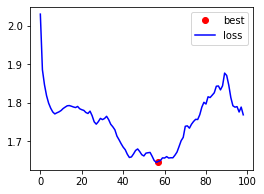

Best epoch so far:  57  smallest loss: 1.6458405399349068
Time taken for the epoch 258.365 sec



In [ ]:
batch_loss = K.constant(0)
X, y = [], []
for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
 
    if ep % 3 == 0:
        plot_history()

    print('Best epoch so far: ',best_ep,' smallest loss:',smallest_loss)
    print('Time taken for the epoch {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)   

- I use the check point at epoch 57 as the inference model.

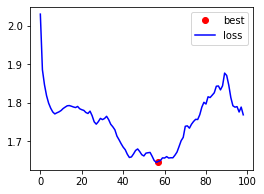

In [ ]:
plot_history()

## Test

In [ ]:
checkpoint.restore(snapshot_folder+'/'+str(emb_dim)+"-ckpt-57") 

In [ ]:
test_bot()

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am afraid not a friend 
%
Greedy| Q: What are you doing ?  A: i am sorry i am going to stay here 
%
Greedy| Q: What your favorite restaurant ?  A: oh yeah sir 
%
Greedy| Q: Who are you ?  A: i am a good time ago 
%
Greedy| Q: Do you want to go out ?  A: i do not know i am not sure 
####################


Input: i like you
Predicted answer: i do not want to hear it 


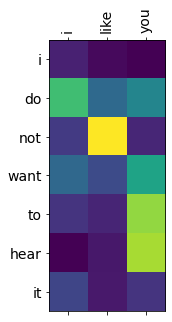

In [ ]:
q = "I like you"
answer(q, training=False)

Input: how do you answer
Predicted answer: oh please 


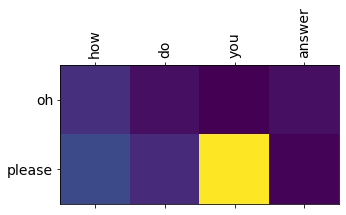

In [ ]:
q = "How do you answer"
answer(q, training=False)

Input: are you hungry
Predicted answer: no 


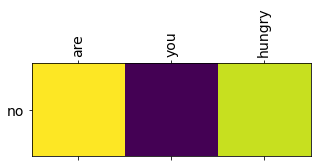

In [ ]:
q = "are you hungry"
answer(q, training=False)

Input: who are you
Predicted answer: i am a good time ago 


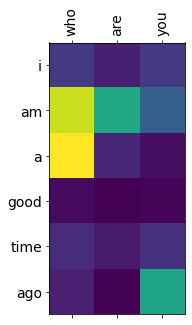

In [ ]:
q = "who are you"
answer(q, training=False)

Input: do you drink
Predicted answer: yes 


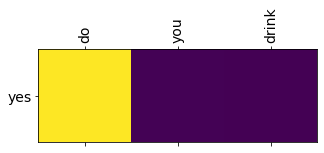

In [ ]:
q = "Do you drink"
answer(q, training=False)